In [1]:
import snntorch as snn
import torch
from torch import nn

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from IPython.display import HTML

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.functional import pad


from tqdm import tqdm
from math import sqrt

import os

#!echo '/data' >> .gitignore

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 0

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
print(f"Running on {device}")

Running on cuda


## vvvvv Utilities vvvvv

In [3]:
class SpikeAnimation():
    def __init__(self, num_plots, color_map = 'coolwarm', frames = None):
        self.to_plot = []
        self.sizes = []
        self.ims = []
        self.color_map = color_map
        self.calc_frames = True
        self.fig, self.axs = plt.subplots(1, num_plots)
        if frames is not None:
            self.frames = frames
            self.calc_frames = False
        return
            
                       
    def add_to_plot(self, three_dim_tensor, size, title):
        assert len(three_dim_tensor.shape) == 3, "Not a three dimensional tensor"
        self.to_plot.append(three_dim_tensor.squeeze(1).detach().numpy())
        self.axs[len(self.to_plot)-1].set_title(title)
        self.sizes.append(size)
        self.ims.append( self.axs[len(self.to_plot)-1].imshow(self.to_plot[-1][0].reshape(size), 
                                      cmap = self.color_map) )
        return
        
    def blit(self, n):
        for iii, image in enumerate(self.ims):
            image.set_array(self.to_plot[iii][n].reshape(self.sizes[iii]))
        return self.ims
    
    def show(self):
        assert len(self.to_plot) != 0, "No spikes loaded"
        ani = matplotlib.animation.FuncAnimation(self.fig, self.blit, frames = self.frames)
        return HTML(ani.to_jshtml())

def quick_animate(three_dim_tensor, size, frames):
    temp = SpikeAnimation(max(2, len(three_dim_tensor)), frames=frames)
    for iii in three_dim_tensor:
        temp.add_to_plot(iii, size, " ")
    return temp.show()

## Building the network (no stdp)

In [4]:
class snn_hmax(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.num_ker1 = 8
        self.num_ker2 = 16
        self.num_stdp = 1
        self.num_classes = 11
        self.stdp_inshallah = nn.Conv2d(in_channels=10, out_channels=self.num_stdp, kernel_size=3, stride=1, padding=1, groups=1, bias=True)
        self.s1 = nn.Conv2d(in_channels=self.num_stdp, out_channels=self.num_ker1, 
                                     kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.c1 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        self.s2 = nn.Conv2d(in_channels=self.num_ker1, out_channels = self.num_ker2,
                                      kernel_size=4, stride=1, padding=0, bias=True)
        self.c2 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        self.fully_connected1 = nn.Linear(self.num_ker2*25, 128)
        self.relu = nn.ReLU()
        self.fully_connected2 = nn.Linear(128, self.num_classes)
        
    def forward(self, input_spikes):
    
        self.stdp_records = []
        self.s1_records = []
        self.c1_records = []
        self.s2_records = []
        self.c2_records = []
        self.output_records = []
        batch_size = input_spikes.shape[1]
        
        #input spikes: [NumSteps, BatSize, 1, 28, 28]
        for iii, step in enumerate(input_spikes):
            #step: [BatchSize, 1, 28,28]
            beg = max(0, iii-5)
            end = min(num_steps, iii+5)
            beg_pad = (beg==0)*(beg-end+10)
            end_pad = (end==num_steps)*(beg-end+10)
            temp = pad(input_spikes[beg:end, :, 0], (0,0,0,0,0,0,beg_pad,end_pad)).movedim(0,1)
            #temp: [BatchSize, LookAheads/LookBacks, 28,28]
            x = self.stdp_inshallah(temp)
            #x: [BatchSize, STDP_out (1), 28,28]
            self.stdp_records.append(x)
            #[BatSize, 1, 28, 28]
            s1_currents = self.s1(x) #X kernels*image_dim1*image_dim2
            #[BatSize, Ker1, 2X, 2X]
            self.s1_records.append(s1_currents)

            max_pooled = self.c1(s1_currents).to(device)
            #[BatSize, Ker1, 1X, 1X]
        
            self.c1_records.append(max_pooled)
                
            s2_convoluteds = self.s2(max_pooled).to(device)
            self.s2_records.append(s2_convoluteds)
            #[BatSize, Ker2, 28, 28]
                                    
            maxpooled2 = self.c2(s2_convoluteds)
            self.c2_records.append(maxpooled2)
            
            #shape [10, 16, 5, 5]
            out = maxpooled2.reshape(maxpooled2.size(0), -1)
            out = self.fully_connected1(out)
            out = self.relu(out)
            out = self.fully_connected2(out)
            self.output_records.append(out)

        self.output_records = torch.stack(self.output_records, dim=0)
        return self.output_records.sum(dim=0)/len(input_spikes)

    def apply_stdp(self, x=True):
        self.stdp_bool = x 
        self.alph.requires_grad_(x)
        self.bet.requires_grad_(x)
    
    def __call__(self, spikes_in):
        return self.forward(spikes_in)

## Initial training

In [5]:
import tonic
import tonic.transforms as transforms
from tqdm import tqdm
import random
from torch.utils.data import DataLoader, Subset
from tonic import DiskCachedDataset

[( 97,  87,  True,      25) (115,  31,  True,      26)
 ( 71,  91, False,      42) ... ( 74, 101,  True, 6460750)
 ( 83, 101,  True, 6460781) ( 79,  94, False, 6460820)]


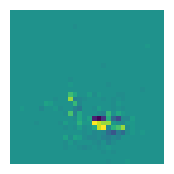

In [6]:
dataset = tonic.datasets.DVSGesture(save_to='./data',
                               train=True)
events, target = dataset[0]
print(events)


sensor_size = tonic.datasets.DVSGesture.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.CropTime(max=1_000_000),
                                      transforms.Downsample(spatial_factor=0.25),
                                      transforms.ToFrame(sensor_size=(32,32,2),
                                                         time_window=10_000)
                                     ])
trainset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

random.seed(seed)
batch_size = 8

subsample_percent = 10
###################### DELETE
train_subsample_idx = random.sample(range(0, len(trainset)), int(len(trainset)*subsample_percent//100))
test_subsample_idx = random.sample(range(0, len(testset)), int(len(testset)*subsample_percent//100))
trainset = Subset(trainset,  train_subsample_idx)
testset= Subset(testset,  test_subsample_idx)
##############################

frames = frame_transform(events)
ani = tonic.utils.plot_animation(frames)
HTML(ani.to_jshtml())

In [7]:
cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

cached_dataloader = DataLoader(cached_trainset, batch_size=batch_size)

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))


def load_sample_batched():
    events, target = next(iter(cached_dataloader))
    events = frame_transform(events)

In [8]:
len(cached_dataloader)

14

In [47]:
y, x = next(iter(train_loader))
a, b = next(iter(train_loader))
y.shape

torch.Size([8, 99, 2, 32, 32])

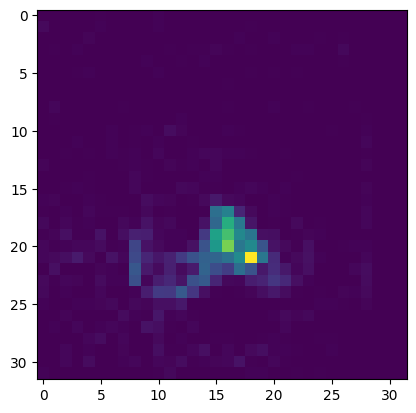

In [48]:
plt.imshow(y[0,:,1].sum(0))

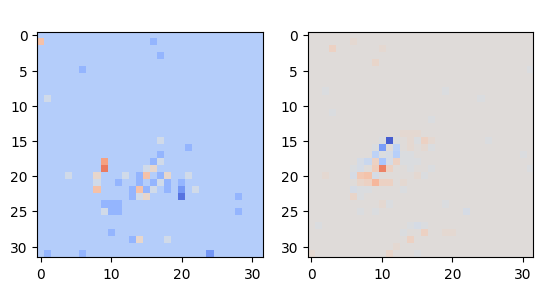

In [49]:
quick_animate([y[0,:,1]-y[0,:,0], a[0,:,1]-a[0,:,0]], (32,32), 99) 

In [21]:
model = snn_hmax().to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
#optimizer = torch.optim.Adam([model.stdp_inshallah.weight], lr=0.001, betas=(0.9, 0.999))

In [23]:
from tqdm.auto import tqdm

num_epochs = 8
loss_hist = []
counter = 0
num_steps = 99
# Outer training loop
num_evaluate = 50
stdp_ker = []
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", position=0, leave=True)):  
        labels = labels.to(device)
        # Forward pass
        ims = (images[:,:num_steps, 1, 3:31, 3:31]-images[:,:num_steps, 0, 3:31,3:31]).unsqueeze(2).movedim(0,1).to(device)
        outputs = model(ims)
        loss = criterion(outputs, labels)
        loss_hist.append(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%50 == 0:
            with torch.no_grad():
                correct = 0
                total = 0
                #print(f"Alpha: {model.alph}, DD {model.past_alph/model.alph}"); model.past_alph = model.alph
                #print(f"Beta: {model.bet}, DD {model.past_beta/model.bet}"); model.past_beta = model.bet
                for j, (test_images, test_labels) in enumerate(tqdm(train_loader, desc="Testing")):
                    if j == num_evaluate:
                        break
                    ims = (test_images[:,:num_steps, 1, 3:31, 3:31]-test_images[:,:num_steps, 0, 3:31,3:31]).unsqueeze(2).movedim(0,1).to(device)
                    test_labels = test_labels.to(device)
                    outputs = model(ims)
                    _, predicted = torch.max(outputs.data, 1)
                    total += test_labels.size(0)
                    correct += (predicted == test_labels).sum().item()
                    if j%50==0:
                        print(f"Predicted: {predicted}")
                        print(f"Labels: {test_labels}")
                    
                print(f'Accuracy of the network: {100*correct/total} %')
        stdp_ker.append(model.s2.weight.detach().cpu().clone())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch 1:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Predicted: tensor([8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')
Labels: tensor([3, 7, 0, 9, 3, 4, 9, 8], device='cuda:0')
Accuracy of the network: 17.757009345794394 %
Epoch [1/8], Loss: 1.4310


Epoch 2:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Predicted: tensor([3, 3, 6, 6, 3, 7, 7, 7], device='cuda:0')
Labels: tensor([10,  3,  6,  9,  1,  7,  7,  7], device='cuda:0')
Accuracy of the network: 34.57943925233645 %
Epoch [2/8], Loss: 1.0171


Epoch 3:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Predicted: tensor([9, 7, 4, 7, 2, 1, 7, 9], device='cuda:0')
Labels: tensor([9, 7, 3, 0, 2, 1, 8, 9], device='cuda:0')
Accuracy of the network: 58.87850467289719 %
Epoch [3/8], Loss: 1.8479


Epoch 4:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Predicted: tensor([ 1,  9,  3,  6,  1,  8,  5, 10], device='cuda:0')
Labels: tensor([ 3,  9,  3,  6,  1,  7,  5, 10], device='cuda:0')
Accuracy of the network: 68.22429906542057 %
Epoch [4/8], Loss: 0.7604


Epoch 5:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Predicted: tensor([ 6, 10,  6,  7,  6,  0,  6,  6], device='cuda:0')
Labels: tensor([ 6, 10,  6,  0,  6,  0,  6,  5], device='cuda:0')
Accuracy of the network: 63.55140186915888 %
Epoch [5/8], Loss: 0.3650


Epoch 6:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Predicted: tensor([4, 0, 6, 0, 6, 6, 4, 0], device='cuda:0')
Labels: tensor([10,  9,  6,  6,  6,  2,  4,  0], device='cuda:0')
Accuracy of the network: 74.76635514018692 %
Epoch [6/8], Loss: 0.4361


Epoch 7:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Predicted: tensor([ 6,  1, 10,  7,  4,  1,  8, 10], device='cuda:0')
Labels: tensor([ 5,  1, 10,  8,  4,  1,  8,  9], device='cuda:0')
Accuracy of the network: 75.70093457943925 %
Epoch [7/8], Loss: 0.6930


Epoch 8:   0%|          | 0/14 [00:00<?, ?it/s]

Testing:   0%|          | 0/14 [00:00<?, ?it/s]

Predicted: tensor([ 1,  6,  7, 10,  4,  0,  6,  0], device='cuda:0')
Labels: tensor([ 1,  6,  7, 10,  4,  0,  6,  7], device='cuda:0')
Accuracy of the network: 74.76635514018692 %
Epoch [8/8], Loss: 0.2665


In [38]:
y, x = next(iter(train_loader))
net = snn_hmax().to(device)
t = (y[:,:99, 1, 3:31, 3:31]-y[:,:99, 0, 3:31, 3:31]).unsqueeze(2).movedim(0,1).to(device)
net(t)

tensor([[ 4.8567e-03, -2.6850e-02, -4.5220e-03, -1.9532e-01, -1.3014e-01,
          2.9423e-01,  1.9873e-01,  8.4655e-02,  1.1097e-01,  1.5802e-02,
         -2.4956e-01],
        [ 3.3697e-02, -9.2870e-02,  1.0406e-01, -9.3695e-02, -2.4278e-01,
          4.9289e-01,  1.2093e-01,  2.8189e-01,  8.9014e-02, -6.6152e-02,
         -3.2893e-01],
        [-4.9522e-02,  6.0985e-02, -3.5940e-02,  8.9776e-02, -1.1063e-01,
          2.3235e-01,  1.6906e-01,  1.9345e-01,  4.0527e-02,  8.4782e-03,
         -1.0922e-01],
        [-1.2651e-02,  6.7063e-02, -7.7275e-02,  4.7527e-03, -9.3169e-02,
          1.6684e-01,  1.4460e-01,  1.4392e-01,  3.4287e-02,  1.5443e-02,
         -7.7738e-02],
        [ 6.1893e-03, -2.2616e-02,  4.0730e-04, -8.1240e-02, -1.5287e-01,
          3.0339e-01,  1.4031e-01,  1.9242e-01,  5.0587e-02, -1.5409e-02,
         -1.9803e-01],
        [ 1.5930e-02,  5.2026e-02, -5.6643e-02,  1.7522e-02, -1.2545e-01,
          2.7262e-01,  1.2590e-01,  1.8942e-01,  5.7877e-03, -2.0275e-0

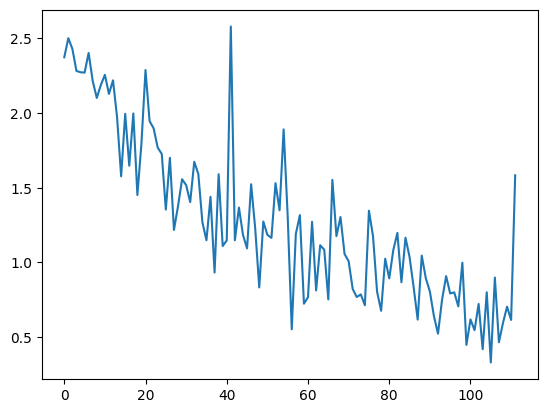

In [15]:
plt.plot([item.cpu().detach().numpy() for item in loss_hist])

In [16]:
quick_animate([stdp_ker[:, 0], stdp_ker[:, 1], 
               stdp_ker[:, -1], stdp_ker[:, -2]], (3,3), 15)

TypeError: list indices must be integers or slices, not tuple

In [29]:
stdp_ker[1][0,0].flatten(0,1)

tensor([ 0.0172, -0.0714,  0.0303, -0.0361,  0.0850, -0.0591,  0.0817,  0.0675,
         0.0112,  0.0690,  0.0048, -0.0565, -0.0457, -0.0844,  0.0380, -0.0393])

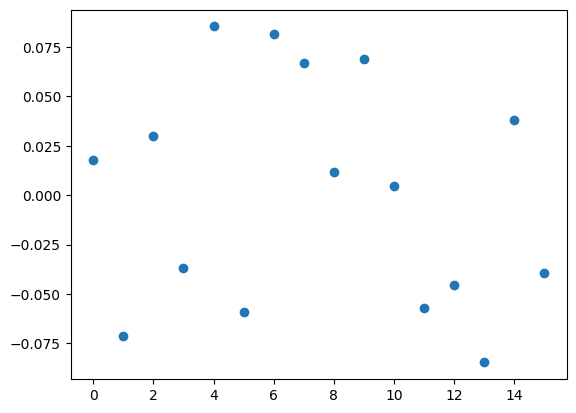

In [30]:
fig, ax = plt.subplots(1, 1)
def animate(jjj):
    ax.clear()
    plt.scatter(range(16),stdp_ker[jjj][0,0].flatten(0,1))
        
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100)

HTML(ani.to_jshtml())

In [ ]:
f = r"./animation.mp4" 
writervideo = matplotlib.animation.FFMpegWriter(fps=60) 
ani.save(f, writer=writervideo)

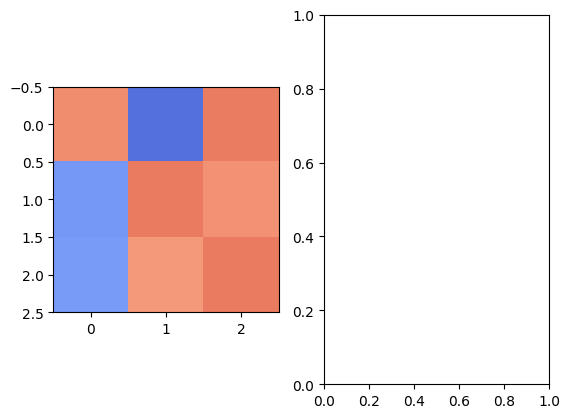

In [68]:
quick_animate([x,], (3,3), 10)

## Visualizing Kernels

In [286]:
print(images[3,:50, 1:, 3:31, 3:31].movedim(0,1)[0].shape)
print(y[:,0].shape)

torch.Size([50, 28, 28])
torch.Size([50, 28, 28])


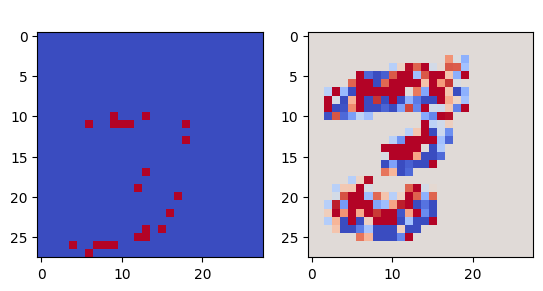

In [287]:
quick_animate([images[3,:50, :1, 3:31, 3:31].movedim(0,1)[0], y[:,0]], (28,28), 50)

In [213]:
test = images[3,:50, 1:, 3:31, 3:31].movedim(0,1)
x = model.s1(test).sum(dim=0)
f, axs = plt.subplots(3,3)
axs[0,0].imshow(test.sum(dim=0)[0])
vertplot=0
horplot=1
for iii in range(8):
    axs[vertplot, horplot].imshow(x[iii].detach().numpy())
    horplot=(horplot+1)%3
    vertplot=vertplot+(horplot%3==0)*1

RuntimeError: Given groups=1, weight of size [8, 1, 3, 3], expected input[1, 50, 28, 28] to have 1 channels, but got 50 channels instead

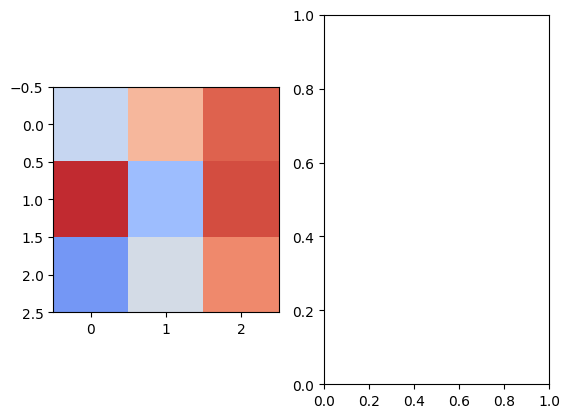

In [185]:
quick_animate([model.s1.weight[:,0]], (3,3), 8)

## Activating STDP, turning off other parameters. Run cell below then training loop again

In [10]:
for parameter in model.parameters():
    parameter.requires_grad_(False)

model.apply_stdp()
print([parameter.requires_grad for parameter in model.parameters()])
print([parameter for parameter in model.parameters()])

[True, True, True, True, True, True, True, True, True, True]
[Parameter containing:
tensor([3.2719, 2.5028, 2.6349, 2.8849, 2.4159, 1.1169, 1.0908, 3.2890, 3.0929,
        1.8512, 2.6380, 1.9645, 1.2458, 0.5325, 1.6390, 3.2857, 2.6763, 1.6310,
        0.7593, 1.4564, 0.6696, 1.0209, 2.9647, 0.9428, 2.8298, 1.2507, 2.9250,
        2.7032, 2.3631, 0.5039, 2.3622, 1.4070, 3.0281, 2.0720, 1.7231, 2.1102,
        1.7517, 1.7406, 1.1315, 2.4770, 1.8121, 0.7244, 1.7120, 2.4659, 2.4745,
        0.5943, 2.2098, 1.6821, 1.4259, 3.1453, 2.0258, 0.7137, 1.6891, 3.3586,
        3.1946, 1.0683, 0.9389, 2.7965, 0.5489, 2.5400, 3.3371, 3.3764, 1.7181,
        1.0373], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.4913, 3.2998, 1.8705, 1.3340, 0.6840, 2.6909, 0.9314, 1.2235, 1.7548,
        1.3844, 2.0604, 1.8511, 0.9503, 2.0274, 2.0311, 1.3712, 2.5357, 2.4302,
        2.3646, 2.6936, 3.0016, 0.9956, 0.8300, 1.3879, 2.3097, 2.1143, 1.7696,
        2.1216, 3.3672, 2.0363, 3.0663,

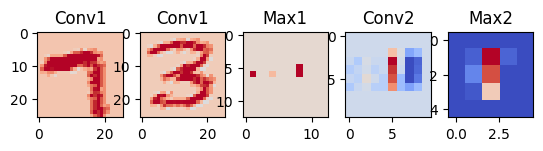

In [70]:
spike_anim = SpikeAnimation(num_plots=5, frames=4)
spike_anim.add_to_plot(model.s1_records[0][1].to('cpu'), (26,26), "Conv1")
spike_anim.add_to_plot(model.s1_records[:][1][0].to('cpu'), (26,26), "Conv1")
spike_anim.add_to_plot(model.c1_records[0][1].to('cpu'), (13, 13), "Max1")
spike_anim.add_to_plot(model.s2_records[0][1].to('cpu'), (10, 10), "Conv2")
spike_anim.add_to_plot(model.c2_records[0][1].to('cpu'), (5, 5), "Max2")
spike_anim.show()

In [8]:
net = snn_hmax().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

In [10]:
num_evaluate = 50

num_epochs = 1
num_iters = 50

loss_hist = []
acc_hist = []

for epoch in range(num_epochs):
    for i, (data, targets) in tqdm(enumerate(iter(trainloader))):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        outputs = net(data)
        loss_val = criterion(outputs, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        with torch.no_grad():
                correct = 0
                total = 0
                for j, (images, labels) in enumerate(trainloader):
                    if j == num_evaluate:
                        break
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = correct/total
        acc_hist.append(acc)
        print(f"Accuracy: {acc*100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
            break

0it [00:02, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[313, 2, 34, 34] to have 1 channels, but got 2 channels instead